### 모듈, 라이브러리

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
from IPython.display import display
from keras import backend as K
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [2]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues) :
    
    if normalize : 
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else :
        print("Confusion matrix, without normalization")
        
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
            

#### 파일 읽기

In [3]:
ecg = pd.read_csv("ecg.csv")
ecg_pattern = pd.read_csv("ecg_pattern.csv")

In [4]:
ecg

,'sample #','MLII','V1','V2','V4','V5',Name
0,0,995.0,NaN,NaN,NaN,1011.0,100
1,1,995.0,NaN,NaN,NaN,1011.0,100
2,2,995.0,NaN,NaN,NaN,1011.0,100
3,3,995.0,NaN,NaN,NaN,1011.0,100
4,4,995.0,NaN,NaN,NaN,1011.0,100
...,...,...,...,...,...,...,...
31199995,649995,946.0,1038.0,NaN,NaN,NaN,234
31199996,649996,946.0,1038.0,NaN,NaN,NaN,234
31199997,649997,945.0,1039.0,NaN,NaN,NaN,234
31199998,649998,948.0,1040.0,NaN,NaN,NaN,234


In [5]:
del ecg_pattern['Unnamed: 0']
ecg_pattern

,Time,Sample,Type,Sub,Chan,Num,Aux,Name
0,0:00.050,18,+,0,0,0,(N,100
1,0:00.214,77,N,0,0,0,NaN,100
2,0:01.028,370,N,0,0,0,NaN,100
3,0:01.839,662,N,0,0,0,NaN,100
4,0:02.628,946,N,0,0,0,NaN,100
...,...,...,...,...,...,...,...,...
112642,30:02.214,648797,N,0,0,0,NaN,234
112643,30:02.889,649040,N,0,0,0,NaN,234
112644,30:03.589,649292,N,0,0,0,NaN,234
112645,30:04.267,649536,N,0,0,0,NaN,234


### EDA

In [6]:
from collections import Counter

Counter(ecg_pattern['Aux'])

Counter({'(N': 530,
         nan: 110919,
         '(P': 60,
         '(B': 221,
         '(VT': 61,
         '(T': 83,
         '(SVTA': 26,
         '(NOD': 36,
         '(IVR': 4,
         '(AFIB': 107,
         '(AFL': 45,
         '(VFL': 6,
         'TS': 6,
         'PSE': 3,
         'MISSB': 428,
         '(AB': 3,
         '(PREX': 103,
         '(BII': 5,
         '(SBR': 1})

In [7]:
type = ["(B", "(N", "(SVTA", "(VT"]

In [8]:
count = Counter(ecg_pattern["Aux"][ecg_pattern["Aux"].isin(type)])
count

Counter({'(N': 530, '(B': 221, '(VT': 61, '(SVTA': 26})

In [9]:
name = ecg["Name"].unique()

In [10]:
import math
import numpy as np

seIdx = []    # [strt_sample_Idx, end_sample_Idx, Name, rythm_type]
idx = 0
for n in name:
    ecg_pattern_temp = ecg_pattern[ecg_pattern["Name"]==n]
    s=0
    for i, r in enumerate(ecg_pattern_temp["Aux"]):
        if(pd.isnull(r)==False):
            if(s!=0):
                n = ecg_pattern_temp["Name"].iloc[i]
                if(i==len(ecg_pattern_temp)-1):
                    e = max(ecg["'sample #'"][ecg["Name"]==n])
                else:
                    e = ecg_pattern_temp["Sample"].iloc[i-1]
                seIdx.append([s, e, n, t])
                s = 0
            if(r in type):
                t = ecg_pattern_temp["Aux"].iloc[i]
                s = ecg_pattern_temp["Sample"].iloc[i]
        else:
            if(s!=0):
                if(i==len(ecg_pattern_temp)-1):
                    n = ecg_pattern_temp["Name"].iloc[i]
                    e = max(ecg[ecg["Name"]==n]["'sample #'"])
                    seIdx.append([s, e, n, t])
            
seIdx

[[18, 649999, 100, '(N'],
 [7, 649999, 101, '(N'],
 [29133, 34058, 102, '(N'],
 [38682, 62825, 102, '(N'],
 [21, 649999, 103, '(N'],
 [22390, 23101, 104, '(N'],
 [32306, 33332, 104, '(N'],
 [54165, 56050, 104, '(N'],
 [58530, 59668, 104, '(N'],
 [64921, 66205, 104, '(N'],
 [69577, 82323, 104, '(N'],
 [99984, 115658, 104, '(N'],
 [129242, 146784, 104, '(N'],
 [151607, 155813, 104, '(N'],
 [158569, 160478, 104, '(N'],
 [170494, 174397, 104, '(N'],
 [178055, 180799, 104, '(N'],
 [183873, 186340, 104, '(N'],
 [194916, 196509, 104, '(N'],
 [203946, 205827, 104, '(N'],
 [208864, 210760, 104, '(N'],
 [213519, 215122, 104, '(N'],
 [217306, 218624, 104, '(N'],
 [228681, 230283, 104, '(N'],
 [233054, 234371, 104, '(N'],
 [540416, 541417, 104, '(N'],
 [589793, 590805, 104, '(N'],
 [67, 649999, 105, '(N'],
 [229, 59769, 106, '(N'],
 [59861, 61277, 106, '(B'],
 [61503, 63499, 106, '(N'],
 [63624, 64035, 106, '(VT'],
 [64349, 257403, 106, '(N'],
 [257493, 258715, 106, '(B'],
 [258921, 268507, 106, '

In [11]:
from tqdm.notebook import tqdm

N = []
B = []
SVTA = []
VT = []
ecg_lst = []

for nn in tqdm(name, desc='name'):
    ecg_temp = ecg[ecg["Name"]==nn]
    for s, e, n, t in tqdm(seIdx, desc='seIdx'):
        if(n!=nn): continue
        si = list(ecg_temp[ecg_temp["'sample #'"]==s].index)[0]
        ei = list(ecg_temp[ecg_temp["'sample #'"]==e].index)[0]
        if(n==102 | n==104):
            ecg_lst = list(ecg_temp["'V5'"].iloc[si:ei+1])
        else:
            ecg_lst = list(ecg_temp["'MLII'"].loc[si:ei+1])
        if(t=="(N"):
            N.append(ecg_lst)
        elif(t=="(B"):
            B.append(ecg_lst)
        elif(t=="(SVTA"):
            SVTA.append(ecg_lst)
        else:
            VT.append(ecg_lst)

In [12]:
print("N : {}".format(len(N)))
print("B : {}".format(len(B)))
print("SVTA : {}".format(len(SVTA)))
print("VT : {}".format(len(VT)))

N : 529
B : 221
SVTA : 26
VT : 61


In [13]:
N = pd.Series(N)
B = pd.Series(B)
SVTA = pd.Series(SVTA)
VT = pd.Series(VT)

결측치 확인

In [14]:
print("// null")
print(N.isnull().values.any())
print(B.isnull().values.any())
print(SVTA.isnull().values.any())
print(VT.isnull().values.any())
print("// na")
print(N.isna().values.any())
print(B.isna().values.any())
print(SVTA.isna().values.any())
print(VT.isna().values.any())

// null
False
False
False
False
// na
False
False
False
False


Oversampling

Window Size를 이용해 기존의 데이터 개수 늘여서 정확도 높은 모델 찾기

In [120]:
from tqdm.notebook import tqdm

window = 200
N = []
B = []
SVTA = []
VT = []
ecg_lst = []

for nn in tqdm(name, desc='name'):
    ecg_temp = ecg[ecg["Name"]==nn]
    for s, e, n, t in tqdm(seIdx, desc='seIdx'):
        if(n!=nn): continue
        si = list(ecg_temp[ecg_temp["'sample #'"]==s].index)[0]
        ei = list(ecg_temp[ecg_temp["'sample #'"]==e].index)[0]
        if(n==102 | n==104):
            ecg_lst = list(ecg_temp["'V5'"].loc[si:ei])
        else:
            ecg_lst = list(ecg_temp["'MLII'"].loc[si:ei])
        if len(ecg_lst) > window:
            while(len(ecg_lst) >= window):
                # rep = rep + 1
                ecg_lst_tmp = ecg_lst[:window]
                del ecg_lst[:window]
                if(t=="(N"):
                    N.append(ecg_lst_tmp)
                elif(t=="(B"):
                    B.append(ecg_lst_tmp)
                elif(t=="(SVTA"):
                    SVTA.append(ecg_lst_tmp)
                else:
                    VT.append(ecg_lst_tmp)
            continue
        else:
            if(n==102 | n==104):
                ecg_lst = list(ecg_temp["'V5'"].loc[si:si+window-1])
            else:
                ecg_lst = list(ecg_temp["'MLII'"].loc[si:si+window-1])
            if(len(ecg_lst) < window):
                continue
        if(t=="(N"):
            N.append(ecg_lst)
        elif(t=="(B"):
            B.append(ecg_lst)
        elif(t=="(SVTA"):
            SVTA.append(ecg_lst)
        else:
            VT.append(ecg_lst)

In [192]:
print("N : {}".format(len(N)))
print("B : {}".format(len(B)))
print("SVTA : {}".format(len(SVTA)))
print("VT : {}".format(len(VT)))


N : 10000
B : 4228
SVTA : 341
VT : 297


In [193]:
N = N[:10000] # undersampling

Label 값을 부여하고 합쳐야 한다.

In [194]:
N = pd.DataFrame(N)
B = pd.DataFrame(B)
SVTA = pd.DataFrame(SVTA)
VT = pd.DataFrame(VT)

In [195]:
N[window] = 0
B[window] = 1
SVTA[window] = 2
VT[window] = 3


In [196]:
X = []
X = pd.DataFrame(X)
X = pd.concat([N, B, SVTA, VT])
# X = X.append(N)
# X = X.append(B)
# X = X.append(VT)
# X = X.append(SVTA)

X

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,990.0,993.0,989.0,988.0,986.0,988.0,993.0,997.0,993.0,986.0,...,973.0,973.0,976.0,974.0,973.0,975.0,973.0,974.0,974.0,0
1,971.0,972.0,972.0,971.0,970.0,971.0,972.0,969.0,968.0,966.0,...,946.0,946.0,945.0,943.0,941.0,944.0,942.0,943.0,942.0,0
2,941.0,942.0,944.0,944.0,945.0,946.0,943.0,942.0,946.0,946.0,...,975.0,974.0,969.0,969.0,971.0,974.0,979.0,980.0,978.0,0
3,971.0,970.0,968.0,967.0,963.0,960.0,956.0,958.0,957.0,957.0,...,954.0,956.0,957.0,958.0,957.0,956.0,952.0,954.0,954.0,0
4,953.0,952.0,953.0,951.0,953.0,954.0,956.0,953.0,954.0,951.0,...,951.0,949.0,947.0,945.0,948.0,947.0,949.0,948.0,946.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,892.0,892.0,898.0,900.0,901.0,905.0,903.0,904.0,901.0,904.0,...,1023.0,1023.0,1025.0,1024.0,1025.0,1022.0,1019.0,1019.0,1015.0,3
293,1015.0,1015.0,1016.0,1016.0,1017.0,1017.0,1018.0,1017.0,1015.0,1014.0,...,986.0,986.0,989.0,991.0,993.0,993.0,993.0,994.0,991.0,3
294,912.0,913.0,914.0,916.0,917.0,921.0,924.0,927.0,933.0,938.0,...,1019.0,1023.0,1022.0,1020.0,1018.0,1015.0,1013.0,1010.0,1010.0,3
295,1009.0,1008.0,1008.0,1008.0,1010.0,1011.0,1016.0,1014.0,1014.0,1012.0,...,957.0,898.0,839.0,783.0,731.0,690.0,651.0,617.0,592.0,3


In [197]:
X = X.reset_index()
X

,index,0,1,2,3,4,5,6,7,8,...,191,192,193,194,195,196,197,198,199,200
0,0,990.0,993.0,989.0,988.0,986.0,988.0,993.0,997.0,993.0,...,973.0,973.0,976.0,974.0,973.0,975.0,973.0,974.0,974.0,0
1,1,971.0,972.0,972.0,971.0,970.0,971.0,972.0,969.0,968.0,...,946.0,946.0,945.0,943.0,941.0,944.0,942.0,943.0,942.0,0
2,2,941.0,942.0,944.0,944.0,945.0,946.0,943.0,942.0,946.0,...,975.0,974.0,969.0,969.0,971.0,974.0,979.0,980.0,978.0,0
3,3,971.0,970.0,968.0,967.0,963.0,960.0,956.0,958.0,957.0,...,954.0,956.0,957.0,958.0,957.0,956.0,952.0,954.0,954.0,0
4,4,953.0,952.0,953.0,951.0,953.0,954.0,956.0,953.0,954.0,...,951.0,949.0,947.0,945.0,948.0,947.0,949.0,948.0,946.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14861,292,892.0,892.0,898.0,900.0,901.0,905.0,903.0,904.0,901.0,...,1023.0,1023.0,1025.0,1024.0,1025.0,1022.0,1019.0,1019.0,1015.0,3
14862,293,1015.0,1015.0,1016.0,1016.0,1017.0,1017.0,1018.0,1017.0,1015.0,...,986.0,986.0,989.0,991.0,993.0,993.0,993.0,994.0,991.0,3
14863,294,912.0,913.0,914.0,916.0,917.0,921.0,924.0,927.0,933.0,...,1019.0,1023.0,1022.0,1020.0,1018.0,1015.0,1013.0,1010.0,1010.0,3
14864,295,1009.0,1008.0,1008.0,1008.0,1010.0,1011.0,1016.0,1014.0,1014.0,...,957.0,898.0,839.0,783.0,731.0,690.0,651.0,617.0,592.0,3


In [198]:
X.reset_index()
del X['index']

In [199]:
X

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,990.0,993.0,989.0,988.0,986.0,988.0,993.0,997.0,993.0,986.0,...,973.0,973.0,976.0,974.0,973.0,975.0,973.0,974.0,974.0,0
1,971.0,972.0,972.0,971.0,970.0,971.0,972.0,969.0,968.0,966.0,...,946.0,946.0,945.0,943.0,941.0,944.0,942.0,943.0,942.0,0
2,941.0,942.0,944.0,944.0,945.0,946.0,943.0,942.0,946.0,946.0,...,975.0,974.0,969.0,969.0,971.0,974.0,979.0,980.0,978.0,0
3,971.0,970.0,968.0,967.0,963.0,960.0,956.0,958.0,957.0,957.0,...,954.0,956.0,957.0,958.0,957.0,956.0,952.0,954.0,954.0,0
4,953.0,952.0,953.0,951.0,953.0,954.0,956.0,953.0,954.0,951.0,...,951.0,949.0,947.0,945.0,948.0,947.0,949.0,948.0,946.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14861,892.0,892.0,898.0,900.0,901.0,905.0,903.0,904.0,901.0,904.0,...,1023.0,1023.0,1025.0,1024.0,1025.0,1022.0,1019.0,1019.0,1015.0,3
14862,1015.0,1015.0,1016.0,1016.0,1017.0,1017.0,1018.0,1017.0,1015.0,1014.0,...,986.0,986.0,989.0,991.0,993.0,993.0,993.0,994.0,991.0,3
14863,912.0,913.0,914.0,916.0,917.0,921.0,924.0,927.0,933.0,938.0,...,1019.0,1023.0,1022.0,1020.0,1018.0,1015.0,1013.0,1010.0,1010.0,3
14864,1009.0,1008.0,1008.0,1008.0,1010.0,1011.0,1016.0,1014.0,1014.0,1012.0,...,957.0,898.0,839.0,783.0,731.0,690.0,651.0,617.0,592.0,3


### Model

* Train : Test = 7 : 3 적용

In [200]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test = train_test_split(X, test_size = 0.3, random_state = 42)
print("X_train : ", len(X_train))
print("X_test : ", len(X_test))


X_train :  10406
X_test :  4460


In [201]:
print(X_train.shape, X_test.shape)

(10406, 201) (4460, 201)


In [202]:
target_train = X_train[X_train.shape[1]-1]
target_test = X_test[X_test.shape[1]-1]
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)
print("Y shape : ", y_train.shape, y_test.shape)

Y shape :  (10406, 4) (4460, 4)


In [203]:
X_train = X_train.iloc[:,:X_train.shape[1] - 1].values
X_test = X_test.iloc[:,:X_test.shape[1] - 1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
print("X shape : ", np.shape(X_train), np.shape(X_test))
print("Y shape : ", np.shape(y_train), np.shape(y_test))

X shape :  (10406, 200, 1) (4460, 200, 1)
Y shape :  (10406, 4) (4460, 4)


* Normalization

In [204]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train)
X_train = minMaxScaler.transform(X_train)
X_test = minMaxScaler.transform(X_test)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

* Wavelet

In [205]:
import pywt
(X_train_cA, X_train_cD) = pywt.dwt(X_train, 'db1')
(X_test_cA, X_test_cD) = pywt.dwt(X_test, 'db1')

#### 모델 관련 함수

In [207]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    f1_precision = precision(y_true, y_pred)
    f1_recall = recall(y_true, y_pred)
    return 2*((f1_precision*f1_recall)/(f1_precision+f1_recall+K.epsilon()))

In [214]:
# Network
def network(X_train, y_train, X_test, y_test) :
    im_shape = (X_train.shape[1], 1)
    
    inputs_cnn = Input(shape = (im_shape), name = 'inputs_cnn')
    # convolutional layer 1, 2
    conv1 = Convolution1D(64, (3), activation = 'relu', input_shape = im_shape)(inputs_cnn)
    conv1 = BatchNormalization()(conv1)
    conv2 = Convolution1D(64, (3), activation = 'relu', input_shape = im_shape)(conv1)
    conv2 = BatchNormalization()(conv2)
    
    # pooling layer 1
    pool1 = MaxPool1D(pool_size = (3), strides = (2), padding = "same")(conv2)
    
    # convolutional layer 3, 4
    conv3 = Convolution1D(128, (3), activation = 'relu', input_shape = im_shape)(pool1)
    conv3 = BatchNormalization()(conv3)
    conv4 = Convolution1D(128, (3), activation = 'relu', input_shape = im_shape)(conv3)
    conv4 = BatchNormalization()(conv4)
    
    # pooling layer 2
    pool2 = MaxPool1D(pool_size = (2), strides = (2), padding = 'same')(conv4)
    
    # convolutional layer 5, 6, 7
    conv5 = Convolution1D(256, (3), activation = 'relu', input_shape = im_shape)(pool2)
    conv5 = BatchNormalization()(conv5)
    conv6 = Convolution1D(256, (3), activation = 'relu', input_shape = im_shape)(conv5)
    conv6 = BatchNormalization()(conv6)
    conv7 = Convolution1D(256, (3), activation = 'relu', input_shape = im_shape)(conv6)
    conv7 = BatchNormalization()(conv7)
    
    # pooling layer 3
    pool3 = MaxPool1D(pool_size = (2), strides = (2), padding = "same")(conv7)
    
    # convolutional layer 8, 9, 10
    conv8 = Convolution1D(512, (3), activation = 'relu', input_shape = im_shape)(pool3)
    conv8 = BatchNormalization()(conv8)
    conv9 = Convolution1D(512, (3), activation = 'relu', input_shape = im_shape)(conv8)
    conv9 = BatchNormalization()(conv9)
    conv10 = Convolution1D(512, (3), activation = 'relu', input_shape = im_shape)(conv9)
    conv10 = BatchNormalization()(conv10)
    
    # pooling layer 4
    pool4 = MaxPool1D(pool_size = (2), strides = (2), padding = "same")(conv10)
    
    # flattened layer 1
    flatten = Flatten()(pool4)
    # dense layer
    dense_end1 = Dense(1024, activation = 'relu')(flatten)
    
    main_output = Dense(4, activation = 'softmax', name = 'main_output')(dense_end1)
    
    model = Model(inputs = inputs_cnn, outputs = main_output)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', recall, precision, f1])
    
    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint(filepath = 'best_model.h5', monitor = 'val_loss', save_best_only = True)]
    
    history = model.fit(X_train, y_train, epochs = 5, callbacks = callbacks, batch_size = 32, validation_data = (X_test, y_test))
    # model.load_weights('best_model.h5')
    return(model, history)
    

In [215]:
def evaluate_model(history, X_test, y_test, model) :
    scores = model.evaluate((X_test), y_test, verbose = 0)
    print("Accuracy : %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc = 'lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model - Loss')
    plt.legend(['Training', 'Validation'], loc = 'upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_name = ['0', '1', '2', '3']
    
    y_true = []
    for element in y_test :
        y_true.append(np.argmax(element))
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis = 1)
    cnf_matrix = confusion_matrix(y_true, prediction)  

* 모델 학습

In [216]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
model, history = network(X_train, y_train, X_test, y_test)


Epoch 1/5
326/326 [==============================] - 84s 258ms/step - loss: nan - accuracy: 0.6686 - recall: nan - precision: nan - f1: nan - val_loss: nan - val_accuracy: 0.6787 - val_recall: nan - val_precision: nan - val_f1: nan
Epoch 2/5
326/326 [==============================] - 89s 273ms/step - loss: nan - accuracy: 0.6701 - recall: nan - precision: nan - f1: nan - val_loss: nan - val_accuracy: 0.6787 - val_recall: nan - val_precision: nan - val_f1: nan


Accuracy : 67.87%


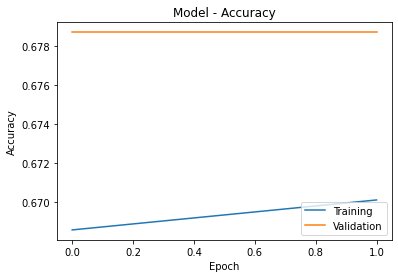

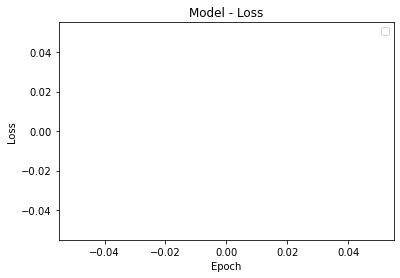

In [217]:
evaluate_model(history, X_test, y_test, model)
y_pred = model.predict(X_test)

In [218]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues) :
    if normalize :
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else : 
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        


Normalized confusion matrix


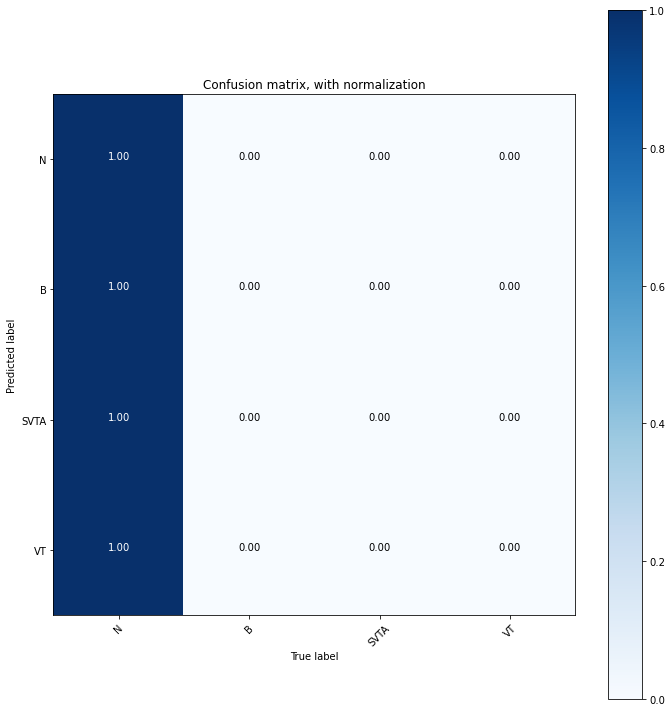

In [219]:
cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
np.set_printoptions(precision = 2)

plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes = ['N', 'B', 'SVTA', 'VT'], normalize = True, title = 'Confusion matrix, with normalization')
plt.show()